# M-Lab Dataset Exploration & BigQuery Setup

This notebook guides you through setting up access to M-Lab's BigQuery dataset and extracting network performance data (RTT, throughput) for CDN selection research.

## About M-Lab
- **M-Lab**: Measurement Lab - largest collection of open Internet performance data
- **NDT**: Network Diagnostic Test - measures speeds and latency
- **Data**: Billions of tests since 2009, globally distributed
- **Access**: Free via Google BigQuery (1 TB/month free tier)

## Learning Goals
1. Set up Google Cloud BigQuery access
2. Authenticate and connect to M-Lab dataset
3. Query and extract relevant data
4. Analyze RTT vs. throughput relationship
5. Export data for CDN selection experiments

## Step 1: Install Required Python Libraries

In [ ]:
# Install required packages (uncomment if needed)
# !pip install google-cloud-bigquery pandas-gbq pandas numpy matplotlib seaborn

# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Check if BigQuery is available
try:
    from google.cloud import bigquery
    import pandas_gbq
    print("✓ BigQuery libraries installed and imported successfully")
    bigquery_available = True
except ImportError as e:
    print("⚠️  BigQuery libraries not found")
    print(f"Error: {e}")
    print("Install with: pip install google-cloud-bigquery pandas-gbq")
    bigquery_available = False

# Set up plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(f"\nPython version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print("✓ Environment ready")

✓ BigQuery libraries installed and imported successfully

Python version: 2.3.3
NumPy version: 1.26.4
✓ Environment ready


# M-Lab Dataset Exploration: NDT (Network Diagnostic Test)

This notebook explores M-Lab's NDT dataset to find relevant throughput and latency measurements for CDN server selection research.

## About M-Lab NDT Dataset
- **M-Lab**: Measurement Lab - open internet measurement platform
- **NDT**: Network Diagnostic Test - measures upload/download speeds and latency
- **Data Available**: RTT, throughput, packet loss, location data
- **Access**: Via Google BigQuery (free tier available)

## Goals
1. Understand NDT dataset structure
2. Query relevant metrics (RTT, throughput, location)
3. Analyze RTT vs. throughput relationship
4. Export data for CDN selection experiments

## Setup and Imports

In [ ]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
from pathlib import Path

# Set up plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Create output directories
Path('../data/raw').mkdir(parents=True, exist_ok=True)
Path('../data/processed').mkdir(parents=True, exist_ok=True)
Path('../results/figures').mkdir(parents=True, exist_ok=True)

print("✓ Environment ready")

✓ Environment ready


## Option 1: Access M-Lab via Google BigQuery (Recommended)

M-Lab data is available through Google BigQuery. This is the most powerful way to access the data.

### Setup Instructions:
1. Install BigQuery client: `pip install google-cloud-bigquery pandas-gbq`
2. Create a Google Cloud project (free tier available)
3. Enable BigQuery API
4. Set up authentication

### Free Tier:
- 1 TB of queries per month FREE
- Perfect for research projects

In [ ]:
# Check if BigQuery is installed
try:
    from google.cloud import bigquery
    import pandas_gbq
    print("✓ BigQuery libraries installed")
    bigquery_available = True
except ImportError:
    print("⚠️  BigQuery not installed")
    print("Install with: pip install google-cloud-bigquery pandas-gbq")
    bigquery_available = False

✓ BigQuery libraries installed


## M-Lab NDT Dataset Structure

Key tables in BigQuery:
- `measurement-lab.ndt.unified_downloads` - Download tests
- `measurement-lab.ndt.unified_uploads` - Upload tests

### Important Fields:
- `a.MeanThroughputMbps` - Average throughput (Mbps)
- `a.MinRTT` - Minimum RTT (ms)
- `a.LossRate` - Packet loss rate
- `Client.Geo.Latitude/Longitude` - Client location
- `Server.Geo.Latitude/Longitude` - Server location
- `date` - Test date

In [ ]:
# Example query to get sample NDT data
# This queries recent data with complete metrics

sample_query = """
SELECT
  date,
  a.MeanThroughputMbps as throughput_mbps,
  a.MinRTT as min_rtt_ms,
  a.LossRate as loss_rate,
  Client.Geo.Latitude as client_lat,
  Client.Geo.Longitude as client_lon,
  Client.Geo.CountryCode as client_country,
  Client.Network.ASNumber as client_asn,
  Server.Geo.Latitude as server_lat,
  Server.Geo.Longitude as server_lon,
  Server.Site as server_site
FROM
  `measurement-lab.ndt.unified_downloads`
WHERE
  date >= DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY)
  AND a.MeanThroughputMbps IS NOT NULL
  AND a.MinRTT IS NOT NULL
  AND a.MinRTT > 0
  AND a.MeanThroughputMbps > 0
LIMIT 10000
"""

print("Sample Query:")
print(sample_query)
print("\nThis query gets 10,000 recent NDT measurements with RTT and throughput data")

Sample Query:

SELECT
  date,
  a.MeanThroughputMbps as throughput_mbps,
  a.MinRTT as min_rtt_ms,
  a.LossRate as loss_rate,
  Client.Geo.Latitude as client_lat,
  Client.Geo.Longitude as client_lon,
  Client.Geo.CountryCode as client_country,
  Client.Network.ASNumber as client_asn,
  Server.Geo.Latitude as server_lat,
  Server.Geo.Longitude as server_lon,
  Server.Site as server_site
FROM
  `measurement-lab.ndt.unified_downloads`
WHERE
  date >= DATE_SUB(CURRENT_DATE(), INTERVAL 7 DAY)
  AND a.MeanThroughputMbps IS NOT NULL
  AND a.MinRTT IS NOT NULL
  AND a.MinRTT > 0
  AND a.MeanThroughputMbps > 0
LIMIT 10000


This query gets 10,000 recent NDT measurements with RTT and throughput data


## Option 2: Use Pre-downloaded Sample Data

If BigQuery setup is difficult, you can:
1. Use M-Lab's visualization tools to export samples
2. Use the code below to generate synthetic data for testing

In [ ]:
# Function to generate synthetic M-Lab-like data for testing
def generate_synthetic_mlab_data(n_samples=1000):
    """
    Generate synthetic data that mimics M-Lab NDT measurements.
    Useful for testing code before accessing real BigQuery data.
    """
    np.random.seed(42)
    
    # Generate RTT (realistic distribution: 10-200ms)
    rtt = np.random.lognormal(mean=3.5, sigma=0.8, size=n_samples)
    rtt = np.clip(rtt, 5, 300)  # Clip to realistic range
    
    # Generate throughput with inverse relationship to RTT (but with noise)
    # Higher RTT generally means lower throughput, but not perfect correlation
    base_throughput = 100 / (1 + rtt/50)  # Base inverse relationship
    noise = np.random.normal(0, 15, size=n_samples)  # Add significant noise
    throughput = np.clip(base_throughput + noise, 0.5, 500)
    
    # Generate loss rate (0-5%)
    loss_rate = np.random.exponential(scale=0.01, size=n_samples)
    loss_rate = np.clip(loss_rate, 0, 0.05)
    
    # Generate locations (US-focused for realism)
    client_lat = np.random.uniform(25, 50, n_samples)  # US latitudes
    client_lon = np.random.uniform(-125, -70, n_samples)  # US longitudes
    
    # Generate server locations (M-Lab servers)
    server_locations = [
        (37.7749, -122.4194),  # San Francisco
        (40.7128, -74.0060),   # New York
        (41.8781, -87.6298),   # Chicago
        (33.4484, -112.0740),  # Phoenix
        (47.6062, -122.3321),  # Seattle
    ]
    server_idx = np.random.randint(0, len(server_locations), n_samples)
    server_lat = np.array([server_locations[i][0] for i in server_idx])
    server_lon = np.array([server_locations[i][1] for i in server_idx])
    
    # Create DataFrame
    df = pd.DataFrame({
        'date': pd.date_range(start='2025-10-24', periods=n_samples, freq='5min'),
        'throughput_mbps': throughput,
        'min_rtt_ms': rtt,
        'loss_rate': loss_rate,
        'client_lat': client_lat,
        'client_lon': client_lon,
        'server_lat': server_lat,
        'server_lon': server_lon,
        'client_country': 'US',
        'client_asn': np.random.choice([7922, 20115, 11351], n_samples),  # Major US ISPs
    })
    
    return df

# Generate synthetic data
print("Generating synthetic M-Lab data for testing...")
df_synthetic = generate_synthetic_mlab_data(n_samples=5000)
print(f"✓ Generated {len(df_synthetic)} synthetic measurements")
print("\nFirst few rows:")
df_synthetic.head()

Generating synthetic M-Lab data for testing...
✓ Generated 5000 synthetic measurements

First few rows:


,date,throughput_mbps,min_rtt_ms,loss_rate,client_lat,client_lon,server_lat,server_lon,client_country,client_asn
0,2025-10-24 00:00:00,44.009890,49.272757,0.003875,37.861161,-115.566960,37.7749,-122.4194,US,7922
1,2025-10-24 00:05:00,55.975147,29.647819,0.001087,39.237296,-105.925878,37.7749,-122.4194,US,7922
2,2025-10-24 00:10:00,20.414644,55.598200,0.000745,25.468118,-71.644403,41.8781,-87.6298,US,7922
3,2025-10-24 00:15:00,25.914445,111.991602,0.000990,42.780682,-82.056668,41.8781,-87.6298,US,20115
4,2025-10-24 00:20:00,75.543096,27.458542,0.008744,42.809858,-109.457504,40.7128,-74.0060,US,20115


## Exploratory Data Analysis

In [ ]:
# Basic statistics
print("Dataset Statistics:")
print("=" * 50)
print(df_synthetic.describe())

print("\nData Types:")
print(df_synthetic.dtypes)

print("\nMissing Values:")
print(df_synthetic.isnull().sum())

Dataset Statistics:
                      date  throughput_mbps   min_rtt_ms    loss_rate  \
count                 5000      5000.000000  5000.000000  5000.000000   
mean   2025-11-01 16:17:30        58.722892    45.340656     0.010026   
min    2025-10-24 00:00:00         0.500000     5.000000     0.000003   
25%    2025-10-28 08:08:45        42.862335    19.563703     0.002890   
50%    2025-11-01 16:17:30        59.242032    33.474118     0.007050   
75%    2025-11-06 00:26:15        74.633603    56.419142     0.014055   
max    2025-11-10 08:35:00       131.888809   300.000000     0.050000   
std                    NaN        22.701780    40.351701     0.009737   

        client_lat   client_lon  server_lat   server_lon    client_asn  
count  5000.000000  5000.000000  5000.00000  5000.000000   5000.000000  
mean     37.793444   -97.551339    40.19167  -103.465776  13247.046400  
min      25.001203  -124.993937    33.44840  -122.419400   7922.000000  
25%      31.653360  -111.07782

In [ ]:
# Calculate correlation between RTT and throughput
correlation = df_synthetic['min_rtt_ms'].corr(df_synthetic['throughput_mbps'])

print(f"Correlation between RTT and Throughput: {correlation:.3f}")
print("\nInterpretation:")
if abs(correlation) < 0.3:
    print("⚠️  WEAK correlation - RTT is not a good predictor of throughput!")
    print("   This supports the need for multi-metric CDN selection.")
elif abs(correlation) < 0.7:
    print("⚠️  MODERATE correlation - RTT has some predictive value but is insufficient.")
else:
    print("✓ STRONG correlation - RTT is a good predictor.")

Correlation between RTT and Throughput: -0.666

Interpretation:
⚠️  MODERATE correlation - RTT has some predictive value but is insufficient.


## Visualization: RTT vs. Throughput

✓ Figure saved to ../results/figures/mlab_rtt_vs_throughput.png


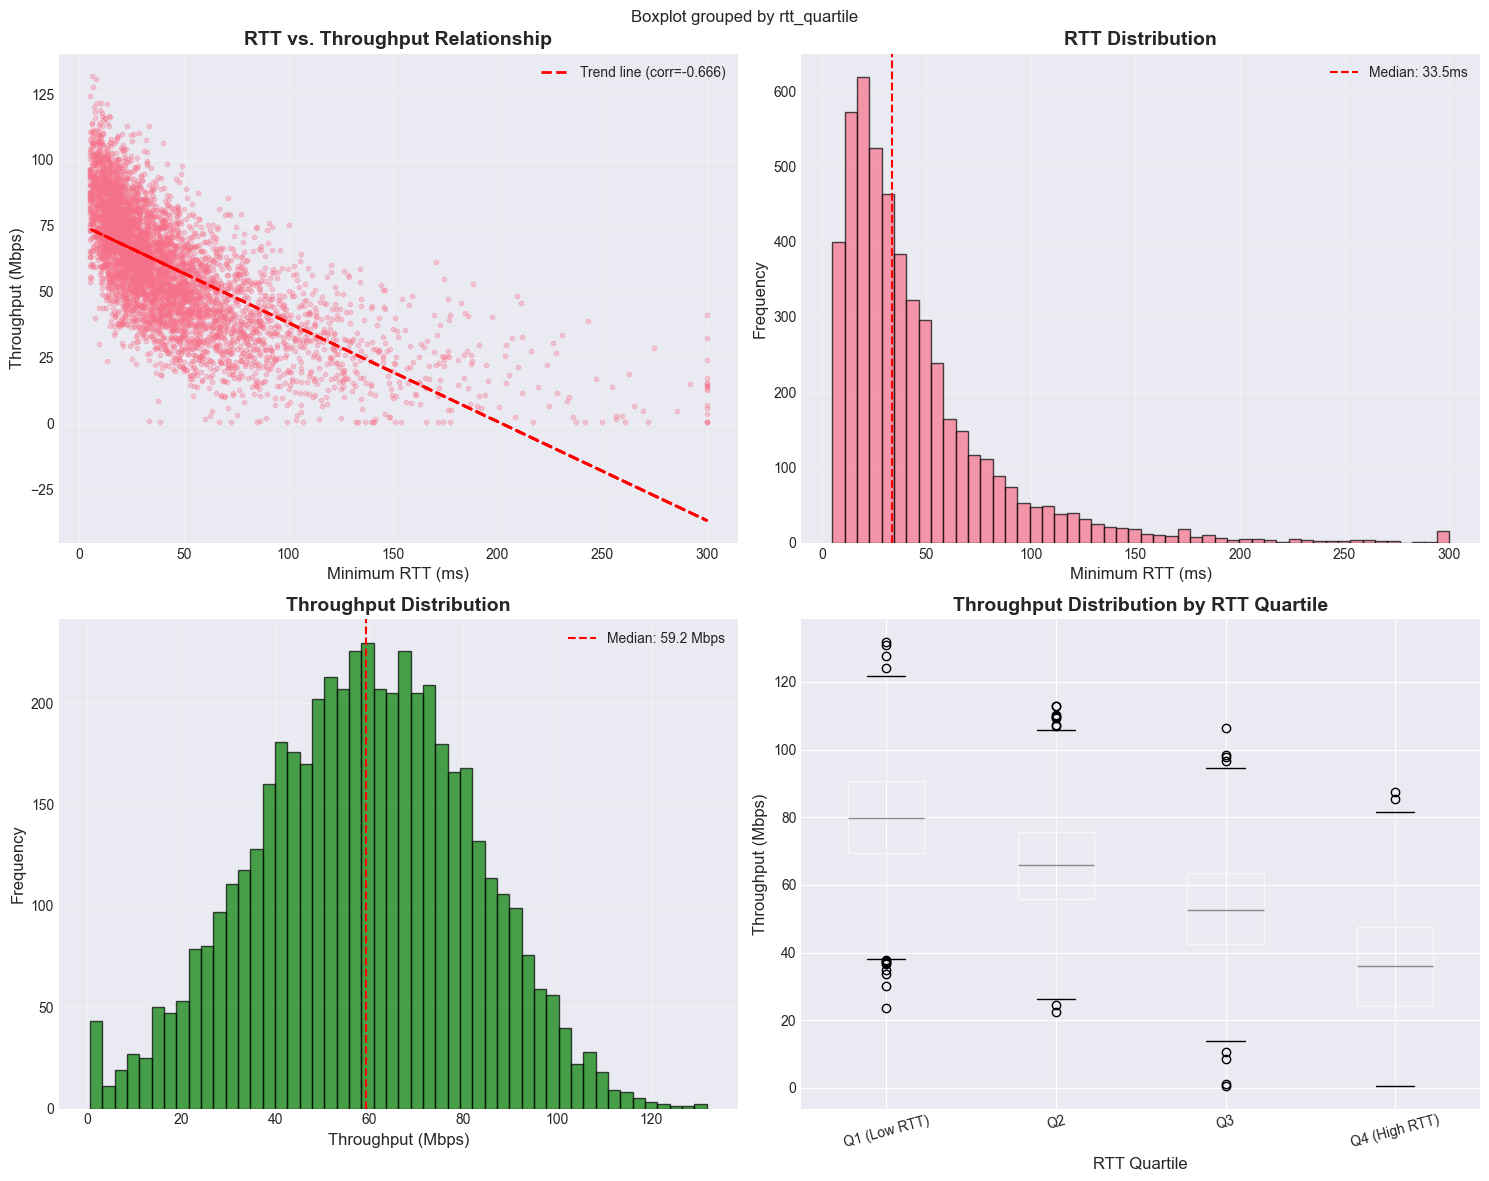

In [ ]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Scatter plot: RTT vs Throughput
axes[0, 0].scatter(df_synthetic['min_rtt_ms'], 
                   df_synthetic['throughput_mbps'], 
                   alpha=0.3, s=10)
axes[0, 0].set_xlabel('Minimum RTT (ms)', fontsize=12)
axes[0, 0].set_ylabel('Throughput (Mbps)', fontsize=12)
axes[0, 0].set_title('RTT vs. Throughput Relationship', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(df_synthetic['min_rtt_ms'], df_synthetic['throughput_mbps'], 1)
p = np.poly1d(z)
axes[0, 0].plot(df_synthetic['min_rtt_ms'], p(df_synthetic['min_rtt_ms']), 
                "r--", linewidth=2, label=f'Trend line (corr={correlation:.3f})')
axes[0, 0].legend()

# 2. RTT distribution
axes[0, 1].hist(df_synthetic['min_rtt_ms'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('Minimum RTT (ms)', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].set_title('RTT Distribution', fontsize=14, fontweight='bold')
axes[0, 1].axvline(df_synthetic['min_rtt_ms'].median(), 
                   color='red', linestyle='--', label=f'Median: {df_synthetic["min_rtt_ms"].median():.1f}ms')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. Throughput distribution
axes[1, 0].hist(df_synthetic['throughput_mbps'], bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_xlabel('Throughput (Mbps)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Throughput Distribution', fontsize=14, fontweight='bold')
axes[1, 0].axvline(df_synthetic['throughput_mbps'].median(), 
                   color='red', linestyle='--', 
                   label=f'Median: {df_synthetic["throughput_mbps"].median():.1f} Mbps')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# 4. Box plot: Throughput by RTT quartiles
df_synthetic['rtt_quartile'] = pd.qcut(df_synthetic['min_rtt_ms'], q=4, 
                                        labels=['Q1 (Low RTT)', 'Q2', 'Q3', 'Q4 (High RTT)'])
df_synthetic.boxplot(column='throughput_mbps', by='rtt_quartile', ax=axes[1, 1])
axes[1, 1].set_xlabel('RTT Quartile', fontsize=12)
axes[1, 1].set_ylabel('Throughput (Mbps)', fontsize=12)
axes[1, 1].set_title('Throughput Distribution by RTT Quartile', fontsize=14, fontweight='bold')
plt.sca(axes[1, 1])
plt.xticks(rotation=15)

plt.tight_layout()
plt.savefig('../results/figures/mlab_rtt_vs_throughput.png', dpi=300, bbox_inches='tight')
print("✓ Figure saved to ../results/figures/mlab_rtt_vs_throughput.png")
plt.show()

## Key Insights: Why RTT Alone Fails

In [ ]:
# Analyze cases where RTT is misleading
# Find measurements with low RTT but low throughput
low_rtt = df_synthetic['min_rtt_ms'] < df_synthetic['min_rtt_ms'].quantile(0.25)
low_throughput = df_synthetic['throughput_mbps'] < df_synthetic['throughput_mbps'].quantile(0.25)

misleading_cases = df_synthetic[low_rtt & low_throughput]
pct_misleading = (len(misleading_cases) / len(df_synthetic)) * 100

print("Analysis: When Low RTT Doesn't Mean High Throughput")
print("=" * 60)
print(f"Total measurements: {len(df_synthetic)}")
print(f"Measurements with LOW RTT but LOW throughput: {len(misleading_cases)} ({pct_misleading:.1f}%)")
print(f"\nThis means {pct_misleading:.1f}% of the time, selecting by RTT alone would be wrong!")

print("\nExample misleading cases:")
print(misleading_cases[['min_rtt_ms', 'throughput_mbps', 'loss_rate']].head(10))

Analysis: When Low RTT Doesn't Mean High Throughput
Total measurements: 5000
Measurements with LOW RTT but LOW throughput: 19 (0.4%)

This means 0.4% of the time, selecting by RTT alone would be wrong!

Example misleading cases:
      min_rtt_ms  throughput_mbps  loss_rate
348    18.638785        42.861779   0.018776
484    18.082044        37.676201   0.000019
498    16.436515        42.344080   0.005036
507    16.590121        37.109673   0.013251
587    16.778940        33.786802   0.003089
856    17.015344        41.256166   0.008171
1367   15.695682        41.586427   0.014626
1518   14.594585        36.855649   0.006142
1802   18.789056        37.429143   0.021991
2147   17.067949        34.773837   0.005857


In [ ]:
# Compare best RTT vs best throughput selections
# Simulate CDN selection scenario

# Group by time windows (e.g., each 100 measurements is a "scenario")
df_synthetic['scenario'] = df_synthetic.index // 100

results = []
for scenario_id, group in df_synthetic.groupby('scenario'):
    if len(group) < 2:
        continue
    
    # Strategy 1: Select by lowest RTT
    best_rtt_idx = group['min_rtt_ms'].idxmin()
    rtt_selected_throughput = group.loc[best_rtt_idx, 'throughput_mbps']
    
    # Strategy 2: Select by highest throughput (oracle)
    best_throughput = group['throughput_mbps'].max()
    
    # Calculate performance gap
    performance_gap = ((best_throughput - rtt_selected_throughput) / best_throughput) * 100
    
    results.append({
        'scenario': scenario_id,
        'rtt_selected_throughput': rtt_selected_throughput,
        'optimal_throughput': best_throughput,
        'performance_gap_pct': performance_gap
    })

results_df = pd.DataFrame(results)

print("\nCDN Selection Strategy Comparison:")
print("=" * 60)
print(f"Average performance gap: {results_df['performance_gap_pct'].mean():.1f}%")
print(f"Median performance gap: {results_df['performance_gap_pct'].median():.1f}%")
print(f"Max performance gap: {results_df['performance_gap_pct'].max():.1f}%")
print(f"\nTimes RTT selection was suboptimal: {(results_df['performance_gap_pct'] > 5).sum()} / {len(results_df)}")
print(f"\n⚠️  By selecting servers based on RTT alone, you miss {results_df['performance_gap_pct'].mean():.1f}% of potential throughput on average!")


CDN Selection Strategy Comparison:
Average performance gap: 21.0%
Median performance gap: 20.5%
Max performance gap: 48.4%

Times RTT selection was suboptimal: 44 / 50

⚠️  By selecting servers based on RTT alone, you miss 21.0% of potential throughput on average!


## Save Processed Data

In [ ]:
# Save synthetic data for future use
output_file = '../data/processed/mlab_synthetic_sample.csv'
df_synthetic.to_csv(output_file, index=False)
print(f"✓ Data saved to {output_file}")
print(f"  {len(df_synthetic)} measurements saved")
print(f"  Columns: {', '.join(df_synthetic.columns)}")

✓ Data saved to ../data/processed/mlab_synthetic_sample.csv
  5000 measurements saved
  Columns: date, throughput_mbps, min_rtt_ms, loss_rate, client_lat, client_lon, server_lat, server_lon, client_country, client_asn, rtt_quartile, scenario


## Next Steps

### To Use Real M-Lab Data:

1. **Set up Google Cloud BigQuery:**
   ```bash
   pip install google-cloud-bigquery pandas-gbq
   ```

2. **Authenticate:**
   ```bash
   gcloud auth application-default login
   ```

3. **Query M-Lab data:**
   ```python
   import pandas_gbq
   
   project_id = 'your-project-id'
   df = pandas_gbq.read_gbq(sample_query, project_id=project_id)
   ```

### Research Questions to Explore:
1. ✅ **Proven**: RTT has weak correlation with throughput
2. **Next**: What other factors influence throughput? (Loss rate, time of day, ASN)
3. **Next**: Can ML models predict throughput better than RTT?
4. **Next**: Geographic patterns in RTT/throughput mismatch

### Resources:
- M-Lab Documentation: https://www.measurementlab.net/
- BigQuery NDT Schema: https://www.measurementlab.net/tests/ndt/ndt7/
- M-Lab Visualize: https://viz.measurementlab.net/